# CrossEntropy Method

## Importance sampling을 통한 estimation
Quantity $l$에 대한 추정을 하는 일반적인 문제를 생각해보자.
$$l=E_\textbf{u}[H(\textbf{X})]=\int H(\textbf{x})f(\textbf{x};\textbf{u}) d\textbf{x}$$

여기서 $H$는 어떤 performance function이며, $f(\textbf{x};\textbf{u})$는 parameter를 가진 distribution function이다. 

Importance sampling을 통해서 다음처럼 추정할 수 있다.

$$\hat{l}=\frac{1}{N}\sum_{i=1}^N H(\textbf{X}_i)\frac{f(\textbf{X}_i;\textbf{u})}{g(\textbf{X}_i)}$$

여기서 $\textbf{X}_1,...,\textbf{X}_N$은 $g$에서 뽑힌 random sample을 의미한다. H함수가 모두 양수를 나타낸다면, 이론적으로 optimal한 g는 다음처럼 주어진다.

$$g^*(\textbf{x})=\frac{H(\textbf{x})f(\textbf{x};\textbf{u})}{l}$$

그러나 이 식에서 $l$은 알 수 없다. Cross-entropy method는 위의 최적화된 $g^*$와 가까운 [parameter를 가진 distribution func.]를 찾는다.

## CrossEntrophy Method
1. $t=1$로 놓는다. $\textbf{v}^0 = \textbf{u}$로 놓는다.(init params)
2. $f(;\textbf{v}^t)$에서 $\textbf{X}_1,...,\textbf{X}_N$를 뽑는다.(sample)
3. 다음을 수행
  * $$\textbf{v}^t=argmax_{v^t}{\frac{1}{N}\sum_{i=1}^N H(\textbf{X}_i)\frac{f(\textbf{X}_i;\textbf{u})}{f(\textbf{X}_i;\textbf{v}^{t-1})}log(f(\textbf{X}_i;\textbf{v}^t))}$$
  * 이 꼴이 사실 -만 취하고 argmin하면 cross-entropy를 minimize하는 꼴이라서 CE method라 한다.
4. 수렴했다고 판단되면 stop, 아니면 2번부터 다시 반복

여기서 argmax를 구하기 위해 $v^t$에 대해서 미분해서 0이 되는 구간을 찾으면 된다.

## CE Method for rare event

rare한 event인 $S(X) > \gamma$에 대한 기대값을 찾고싶다. 즉, $E_{x~p}[S(X) > \gamma]$를 위한 sample function을 얻는 방법이다.

1. $t=1$로 놓는다. $\textbf{v}^0$을 적절히 initialize한다. (init params) (실험 시, $\textbf{u}$로 놓으면 잘 안되는 경우가 생김)
2. $f(;\textbf{v}^t)$에서 $\textbf{X}_1,...,\textbf{X}_N$를 뽑는다.(sample)
3. 위에서 뽑은 sample들에 대해서 $S(X)$로 score를 매긴다.
4. 일정 percentage 이상의 sample의 score를 threshold $\hat{\gamma}$로 놓는다.
5. $\hat{\gamma} > \gamma$면 $\hat{\gamma} = \gamma$로 놓는다.
6. $\hat{\gamma}$를 넘는 sample에 대해 $\textbf{v}^t$를 수정 (위의 3번식의 gradient가 0이 되는 v를 찾는다)
7. 수렴했다고 판단($\hat{\gamma} == \gamma$)되면 stop, 아니면 2번부터 다시 반복

> 그런데 가우시안 미분이 복잡해서 저걸 구하기가 귀찮네.. 예제는 CE Method의 변형이라 봐야겠군...

## 예제

### 예제 1번

$p(x)=N(0, 1)$, $H(x)=N(1, 1)$로 만들고 $H(x)> 0.1$인 구간에 대해서 importance sampling을 진행한다고 가정한다. 

그렇다면 $[H(x)>0.1]*p(x)$가 0이 아닌 구간이 optimal한 $q$일 것이다.

In [2]:
import numpy as np
from scipy.stats import norm
import math

import matplotlib.pyplot as plt

def normpdf(x, mean, sd):
    '''
    normal pdf distribution을 정의한다. x, mean, sd를 넣으면 x에 대한 확률값을 return
    '''
    var = float(sd)**2
    pi = 3.14159265
    denom = (2*pi*var+0.0000001)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var+0.0000001))
    return num/denom

def tripdf(x, mean, dummy_sd):
    '''
    시험삼아 만든 mean을 기준으로 -0.5~+0.5로 된 삼각형 distribution.
    dummy_sd는 쓰이지 않으나 함수 입력을 똑같이 하기 위해 dummy로...
    '''
    if x < (mean-0.5):
        return 0
    elif x > mean+0.5:
        return 0
    elif x < mean:
        return 0.5-(mean-x)
    elif x > mean:
        return 0.5-(x-mean)
pdf = normpdf  # 다른 pdf에서 해보고싶으면 tripdf를 쓰면 됨.

class Q:
    '''
    실제로 sample을 할 녀석... normal pdf로 만들었다.
    '''
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def draw(self, size):
        return np.random.normal(self.mean, self.std, size)

    def prob(self, x):
        return normpdf(x, self.mean, self.std)

### distribution setting
$p(x)=N(0, 1)$, $H(x)=N(2, 1)$와 $p(x)*H(x)$를 그려본다.

> 사실 rare한 event에 대해서 해야하지만 그림이 안이쁘다... H(x)의 mean을 10으로 놓고 해봐도 된다.

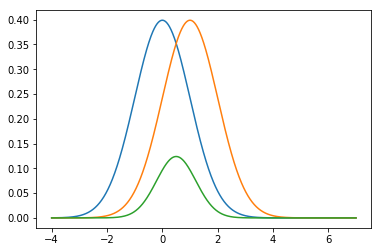

In [3]:
def p(x):
    return pdf(x, 0, 1)
def H(x):
    return pdf(x, 1, 1)

xs = np.linspace(-4, 7, 1000)

pxs = [p(x) for x in xs]
Hxs = [H(x) for x in xs]
pxHxs = [p(x)*H(x) for x in xs]

plt.plot(xs,pxs)
plt.plot(xs,Hxs)
plt.plot(xs,pxHxs)

plt.show()

In [4]:
q = Q(0, 10)

n_sample=1000
draw_list = []
best_list = []
thr_upper = 0.1
alpha = 0.7
percentile = 10  # 10프로만 남기고 다 버려야지...

for i in range(100):
    q_draw = q.draw(n_sample)
    
    if i % 4 == 0:
        print("mean: {: .3f}, std: {: .3f}".format(q.mean, q.std))
        draw_list.append(q_draw)
    
    Hx = [H(i) for i in q_draw]
    
    # adaptive threshold
    # 0.1보다 낮은 녀석도 많이 나올 수 있기때문에...
    thr = np.percentile(Hx, percentile)
    print("threshold: {}".format(thr))
    if thr > thr_upper:
        thr = thr_upper
        break
    # thr보다 높은 녀석들만 sample로 넣는다.
    idxs = [i for i, h in enumerate(Hx) if h > thr]
    best_samples = q_draw[idxs]
    
    if i % 4 == 0:
        best_list.append(q_draw[idxs])

    # 여기서 사실 gradient로 구해야함!!
    mu = np.mean(best_samples)
    sd = np.std(best_samples) + 0.001
    
    # update parameter
    q.mean = (1-alpha)*q.mean + alpha*mu
    q.std = (1-alpha)*q.std + alpha*sd
print("mean: {: .3f}, std: {: .3f}".format(q.mean, q.std))
draw_list.append(q_draw)
best_list.append(q_draw[idxs])
print("finished at {}-th iteration".format(i))

mean:  0.000, std:  10.000
threshold: 4.338665522091517e-56
threshold: 2.1537073208812399e-44
threshold: 7.112204110135957e-33
threshold: 7.858395348306199e-24
mean:  0.624, std:  5.306
threshold: 3.010513584608481e-17
threshold: 2.3216725427206054e-13
threshold: 1.9046367854288572e-10
threshold: 2.9320608714446386e-07
mean:  0.956, std:  2.795
threshold: 5.502459948520282e-06
threshold: 0.0003076619065077131
threshold: 0.001954234555158739
threshold: 0.00687107112413953
mean:  0.939, std:  1.455
threshold: 0.029472648995481764
threshold: 0.05163565392473043
threshold: 0.09160709532060277
threshold: 0.13263573387283487
mean:  0.967, std:  0.884
finished at 15-th iteration


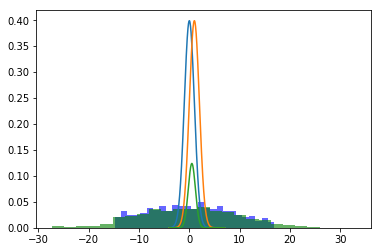

-0.101767263337


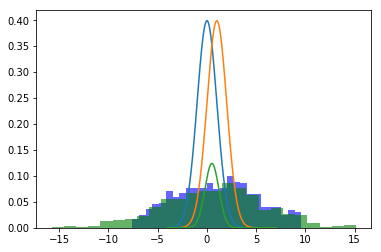

0.678433129366


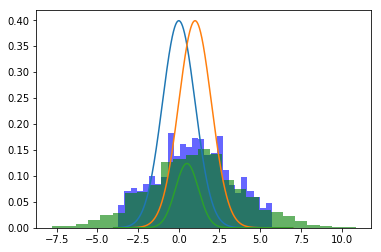

0.977477957508


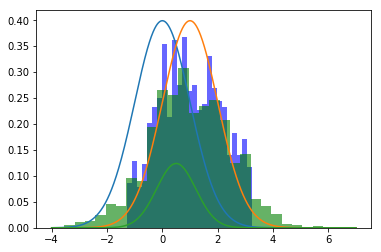

0.986310482964


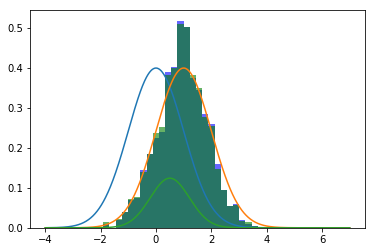

0.944061556094


In [5]:
for best, draw in zip(best_list, draw_list):
    plt.hist(best, bins=25, normed=True, alpha=0.6, color='b')
    plt.hist(draw, bins=25, normed=True, alpha=0.6, color='g')
    plt.plot(xs,pxs)
    plt.plot(xs,Hxs)
    plt.plot(xs,pxHxs)
    plt.show()
    print(np.mean(draw))

위그래프를 보면 우리가 원하는 score function에 잘 찾아가는 것을 볼 수 있다.

그런데 사실 sample을 뽑는 true distribution(파란색)을 안다면 굳이 p(x)가 0이 되는 구간은 뽑지 않는것이 좋겠다.

### 예제 2번

똑같은 문제인데, p(x)H(x)에 대해서 풀어본다.

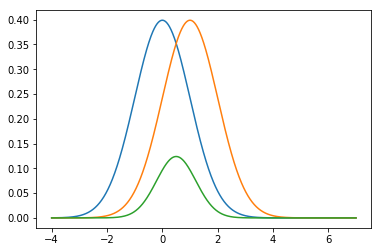

In [48]:
plt.plot(xs,pxs)
plt.plot(xs,Hxs)
plt.plot(xs,pxHxs)

plt.show()

In [49]:
q = Q(-10, 100)

n_sample=1000
draw_list = []
best_list = []
thr_upper = 0.01
alpha = 0.7
percentile = 10  # 10프로만 남기고 다 버려야지...

for i in range(100):
    q_draw = q.draw(n_sample)
    
    if i % 4 == 0:
        print("mean: {: .3f}, std: {: .3f}".format(q.mean, q.std))
        draw_list.append(q_draw)
    
    px = [p(i) for i in q_draw]
    Hx = [H(i) for i in q_draw]
    
    performance = np.array([p*h for p, h in zip(px, Hx)])
    thr = np.percentile(performance, percentile)
    print("threshold: {}".format(thr))
    if thr > thr_upper:
        thr = thr_upper
        break
    idxs = [i for i, p in enumerate(performance) if p > thr]
    best_samples = q_draw[idxs]

    if i % 4 == 0:
        best_list.append(q_draw[idxs])
    mu = np.mean(best_samples)
    sd = np.std(best_samples) + 0.001
    
    # update parameter
    q.mean = (1-alpha)*q.mean + alpha*mu
    q.std = (1-alpha)*q.std + alpha*sd
print("mean: {: .3f}, std: {: .3f}".format(q.mean, q.std))
draw_list.append(q_draw)
best_list.append(q_draw[idxs])
print("finished at {}-th iteration".format(i))

mean: -10.000, std:  100.000
threshold: 0.0
threshold: 0.0
threshold: 0.0
threshold: 0.0
mean:  0.642, std:  14.323
threshold: 1.7966892141602613e-238
threshold: 2.2046802176704854e-186
threshold: 4.835409793730799e-129
threshold: 2.661079025906743e-102
mean:  0.204, std:  7.746
threshold: 6.840669548157965e-66
threshold: 1.668761791739824e-47
threshold: 4.8070564393451e-37
threshold: 9.43032680270374e-26
mean:  0.497, std:  3.991
threshold: 4.381261237981444e-19
threshold: 1.063284574772661e-13
threshold: 3.748185084073801e-10
threshold: 2.4082472398084768e-08
mean:  0.496, std:  2.048
threshold: 6.816515039421885e-07
threshold: 6.497591050496692e-05
threshold: 0.00039268779425442435
threshold: 0.001358073104311574
mean:  0.550, std:  1.090
threshold: 0.005656675444913597
threshold: 0.013913929319508833
mean:  0.537, std:  0.917
finished at 21-th iteration


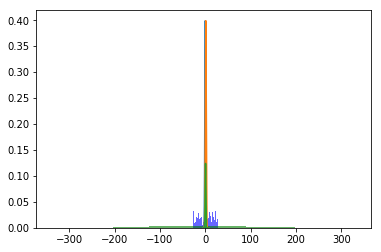

-11.7197677458


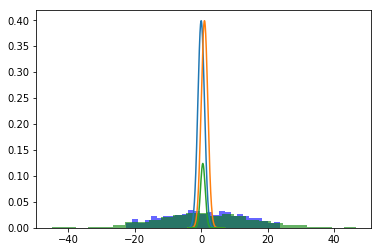

1.24777547395


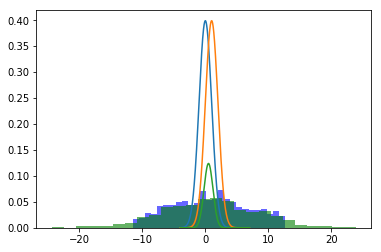

0.733421949882


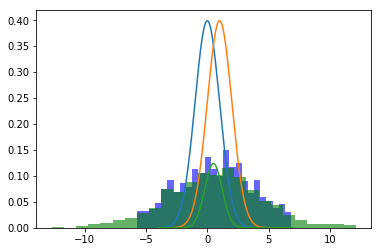

0.559138041774


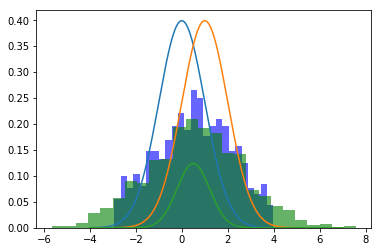

0.588339319474


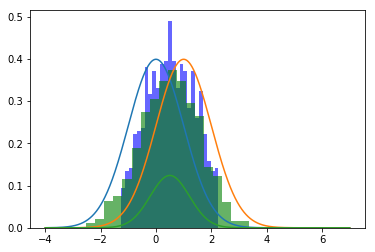

0.50848171697


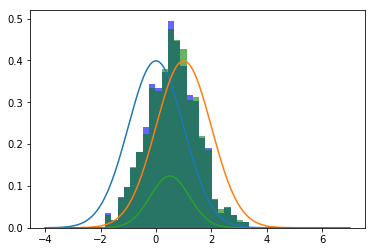

0.601981902906


In [50]:
for best, draw in zip(best_list, draw_list):
    plt.hist(best, bins=25, normed=True, alpha=0.6, color='b')
    plt.hist(draw, bins=25, normed=True, alpha=0.6, color='g')
    plt.plot(xs,pxs)
    plt.plot(xs,Hxs)
    plt.plot(xs,pxHxs)
    plt.show()
    print(np.mean(draw))

## RL에 적용은?

RL에 적용하려하면 Policy를 p(z)로 놓고($\pi(a;s)$), Reward를 H(z)로 놓는다. 사실 이 때에는 $p(z)$가 우리가 정한 pdf이며, $g^{t-1}(z)$와 같기때문에 Importance sampling은 아니라고 볼 수 있다.(likelihood ratio = 1)